### А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

## Задача
- Запустите A/A-тест
- Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
- Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента
- Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

## Описание колонок
- `experimentVariant` – вариант эксперимента
- `version` – версия приложения
- `purchase` – факт покупки

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=";").drop(columns=['Unnamed: 0'])
df.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


### проверим целостность данных на нули, типы данных и дубликаты. Также ознакомимся с некотоыми из них подробнее

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127018 entries, 0 to 127017
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   uid                127018 non-null  object
 1   experimentVariant  127018 non-null  int64 
 2   version            127018 non-null  object
 3   purchase           127018 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.9+ MB


In [4]:
df.duplicated().sum()

0

In [5]:
df['purchase'].value_counts() # мало ли тут ошибки в значениях

0    122104
1      4914
Name: purchase, dtype: int64

In [6]:
df.version.value_counts() # 4 варианта версий, важно, чтобы в сплитовалка сделала разделила их поровну между 2мя группами

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

In [7]:
df.experimentVariant.value_counts()

1    63916
0    63102
Name: experimentVariant, dtype: int64

### Первое, что надо сделать - запустить тест и убедиться, что сплит система сломана и разница между группами есть. Для этого надо сформировать 2 выбокри. Первое, что приходит в голову - сделать пивот таблицу, чтобы отделить 2 выбокри друг от друга. Далее для удобства я бы просто разделил их на 2 таблицы, чтобы пустые значения не мешались

In [8]:
var1 = df.pivot(index=['uid', 'version'], columns='experimentVariant', values='purchase') \
        .reset_index() \
        .rename(columns={0: 'var0', 1: 'var1'}) \
        .query('var0 != var0')[['uid', 'version', 'var1']]
var1.head()

experimentVariant,uid,version,var1
0,00003e3b9e5336685200ae85d21b4f5e,v3.7.4.0,0.0
1,000053b1e684c9e7ea73727b2238ce18,v2.8.0,0.0
5,0004289ee1c7b8b08c77e19878106ae3,v2.8.0,0.0
6,0004d0b59e19461ff126e3a08a814c33,v2.8.0,0.0
9,0006246bee639c7a7b11a08e34dd3cc6,v2.9.0,0.0


In [9]:
var0 = df.pivot(index=['uid', 'version'], columns='experimentVariant', values='purchase') \
        .reset_index() \
        .rename(columns={0: 'var0', 1: 'var1'}) \
        .query('var1 != var1')[['uid', 'version', 'var0']]
var0.head()

experimentVariant,uid,version,var0
2,0001261e2060303a06ba6c64d676d639,v3.8.0.0,0.0
3,00029153d12ae1c9abe59c17ff2e0895,v2.8.0,0.0
4,0002ac0d783338cfeab0b2bdbd872cda,v2.8.0,0.0
7,00053f5e11d1fe4e49a221165b39abc9,v2.8.0,0.0
8,00056c20eb5a029583db75506953f1d9,v2.8.0,0.0


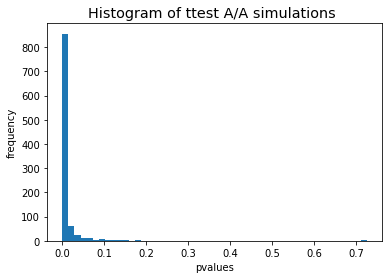

0.944

In [10]:
simulations = 1000  # число сравнений двух выборок
n_s = 1000          # размер выборки
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = var0['var0'].sample(n_s, replace = False).values
    s2 = var1['var1'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем p-value

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем количество ложноположительных случаев FPR
sum(np.array(res) <0.05) / simulations

### Действительно сплит система сломана - очень много кейсов (почти все), когда между выборками были замечены различия. Дальше надо выяснить, в чем причина. Признаков деления в таблице немного - версия системы. Посмотрим на их число в каждой выборке

In [11]:
var0.version.value_counts()

v2.8.0      41283
v2.9.0      11921
v3.8.0.0     5694
v3.7.4.0     4204
Name: version, dtype: int64

In [12]:
var1.version.value_counts()

v2.8.0      41552
v2.9.0      12033
v3.8.0.0     6110
v3.7.4.0     4221
Name: version, dtype: int64

### на первый взгляд особой разницы нет, однако сначала отберем только те версии, где число равное

In [18]:
var11 = var1.query('version == "v2.9.0" or version == "v3.7.4.0"')
var11.var1.value_counts()

0.0    15130
1.0     1124
Name: var1, dtype: int64

In [24]:
var00 = var0.query('version == "v2.9.0" or version == "v3.7.4.0"')
var00.var0.value_counts()

0.0    14983
1.0     1142
Name: var0, dtype: int64

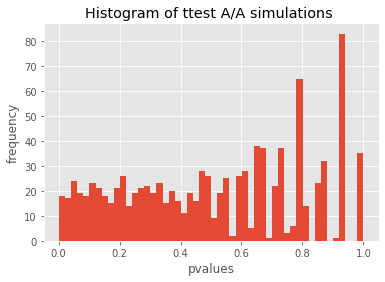

0.042

In [26]:
simulations = 1000  # число сравнений двух выборок
n_s = 1000          # размер выборки
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = var00['var0'].sample(n_s, replace = False).values
    s2 = var11['var1'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем p-value

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем количество ложноположительных случаев FPR
sum(np.array(res) <0.05) / simulations

### с версиями v2.9.0 и v3.7.4.0 все нормально, попробуем добавить еще одну - 2.8.0

In [27]:
var111 = var1.query('version != "v3.8.0.0"')
var111.var1.value_counts()

0.0    54787
1.0     3019
Name: var1, dtype: int64

In [28]:
var000 = var0.query('version != "v3.8.0.0"')
var000.var0.value_counts()

0.0    56225
1.0     1183
Name: var0, dtype: int64

### конверсии значительно различаются. Проверим

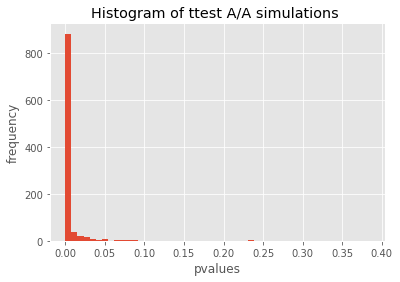

0.97

In [29]:
simulations = 1000  # число сравнений двух выборок
n_s = 1000          # размер выборки
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = var000['var0'].sample(n_s, replace = False).values
    s2 = var111['var1'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем p-value

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем количество ложноположительных случаев FPR
sum(np.array(res) <0.05) / simulations

### Проверим также версию v3.8.0.0

In [31]:
var1111 = var1.query('version != "v2.8.0"')
var1111.var1.value_counts()

0.0    20856
1.0     1508
Name: var1, dtype: int64

In [30]:
var0000 = var0.query('version != "v2.8.0"')
var0000.var0.value_counts() # скорее всего различий не будет

0.0    20349
1.0     1470
Name: var0, dtype: int64

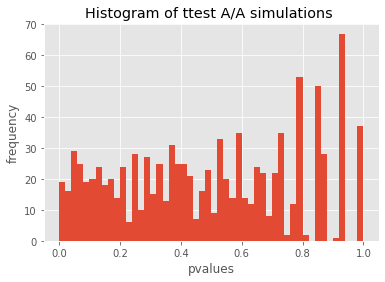

0.051

In [34]:
simulations = 1000  # число сравнений двух выборок
n_s = 1000          # размер выборки
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = var0000['var0'].sample(n_s, replace = False).values
    s2 = var1111['var1'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем p-value

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем количество ложноположительных случаев FPR
sum(np.array(res) <0.05) / simulations

In [35]:
var1.query('version == "v2.8.0"').var1.value_counts()

0.0    39657
1.0     1895
Name: var1, dtype: int64

In [36]:
var0.query('version == "v2.8.0"').var0.value_counts()

0.0    41242
1.0       41
Name: var0, dtype: int64

### Различий нет - проблема в версии 2.8.0. Слишком отличаются конверсии в двух группах между собой именно в этой версии. Возможно проблема заключается в том, что люди из одной страны пользуются одной версией (и покупают чаще), а другие нет. Либо могут быть любые другие признаки, почему такая разница в конверсиях. При проведении A/B-тестов эту версию приложения нужно будет убрать (или наладить систему сплитования)